### Deskripsi Dataset dan Tujuan Analisis
Dataset berisi data absensi dan nilai siswa. Tujuan analisis adalah mengklasifikasikan performa siswa menggunakan sistem fuzzy (Mamdani & Sugeno) serta membandingkan kinerjanya.

In [28]:
# 1. Import Library
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [29]:
# 2. Load Dataset & Preprocessing
df = pd.read_csv("./data/dataset_siswa.csv")
df['absensi'] = df['absensi'].fillna(df['absensi'].mean())
df['nilai'] = df['nilai'].fillna(df['nilai'].mean())

In [30]:
# 3. Kategorisasi Performa Siswa (Ground Truth)
def categorize_performance(row):
    absensi = row['absensi']
    nilai = row['nilai']
    if (absensi < 40 and nilai < 40):
        return 'Buruk'
    elif (absensi < 40 and 40 <= nilai < 70):
        return 'Buruk'
    elif (40 <= absensi < 70 and nilai < 40):
        return 'Buruk'
    elif (absensi >= 70 and nilai >= 70):
        return 'Bagus'
    elif (absensi >= 70 and 40 <= nilai < 70):
        return 'Bagus'
    elif (40 <= absensi < 70 and nilai >= 70):
        return 'Bagus'
    else:
        return 'Cukup'
df['performa'] = df.apply(categorize_performance, axis=1)

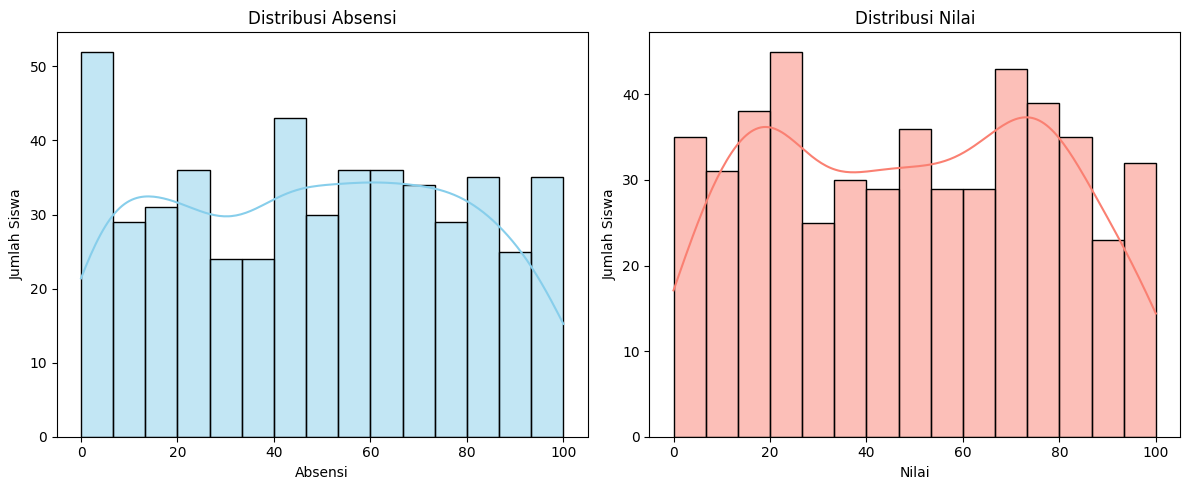

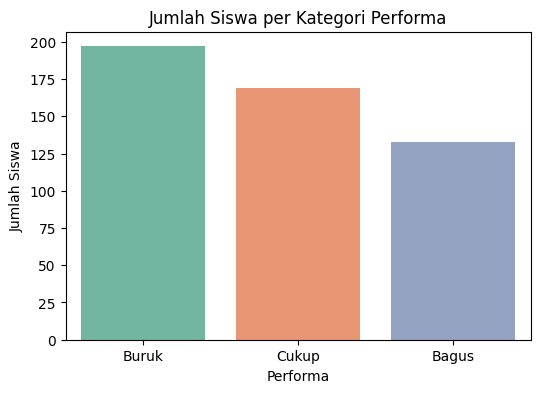

In [31]:
# 4. Visualisasi Distribusi Data
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['absensi'], kde=True, bins=15, color='skyblue')
plt.title('Distribusi Absensi')
plt.xlabel('Absensi')
plt.ylabel('Jumlah Siswa')
plt.subplot(1,2,2)
sns.histplot(df['nilai'], kde=True, bins=15, color='salmon')
plt.title('Distribusi Nilai')
plt.xlabel('Nilai')
plt.ylabel('Jumlah Siswa')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='performa', hue='performa', data=df, palette='Set2', legend=False)
plt.title('Jumlah Siswa per Kategori Performa')
plt.xlabel('Performa')
plt.ylabel('Jumlah Siswa')
plt.show()

In [32]:
# 5. Fungsi Keanggotaan Gaussian
def gaussian_membership(x, center, sigma):
    return np.exp(-0.5 * ((x - center) / sigma) ** 2)

In [33]:
# 6. Fuzzy Inference Mamdani (output konstan)
def fuzzy_inference_mamdani(absensi, nilai):
    absensi_rendah = gaussian_membership(absensi, 0, 15)
    absensi_sedang = gaussian_membership(absensi, 50, 15)
    absensi_tinggi = gaussian_membership(absensi, 100, 15)
    nilai_rendah = gaussian_membership(nilai, 0, 15)
    nilai_sedang = gaussian_membership(nilai, 50, 15)
    nilai_tinggi = gaussian_membership(nilai, 100, 15)
    alpha = [
        min(absensi_rendah, nilai_rendah),   # rule 1
        min(absensi_rendah, nilai_sedang),   # rule 2
        min(absensi_rendah, nilai_tinggi),   # rule 3
        min(absensi_sedang, nilai_rendah),   # rule 4
        min(absensi_sedang, nilai_sedang),   # rule 5
        min(absensi_sedang, nilai_tinggi),   # rule 6
        min(absensi_tinggi, nilai_rendah),   # rule 7
        min(absensi_tinggi, nilai_sedang),   # rule 8
        min(absensi_tinggi, nilai_tinggi),   # rule 9
    ]
    output = [
        0.0, 0.0, 0.5,
        0.0, 0.5, 1.0,
        0.5, 1.0, 1.0
    ]
    numerator = sum(a * o for a, o in zip(alpha, output))
    denominator = sum(alpha)
    return 0.5 if denominator == 0 else numerator / denominator

In [34]:
# 7. Fuzzy Inference Sugeno (output linear)
def fuzzy_inference_sugeno(absensi, nilai):
    # Output rule berupa fungsi linear dari input
    output = [
        0.2 * absensi + 0.2 * nilai,  # rule 1
        0.2 * absensi + 0.5 * nilai,  # rule 2
        0.2 * absensi + 0.8 * nilai,  # rule 3
        0.5 * absensi + 0.2 * nilai,  # rule 4
        0.5 * absensi + 0.5 * nilai,  # rule 5
        0.5 * absensi + 0.8 * nilai,  # rule 6
        0.8 * absensi + 0.2 * nilai,  # rule 7
        0.8 * absensi + 0.5 * nilai,  # rule 8
        0.8 * absensi + 0.8 * nilai,  # rule 9
    ]
    absensi_rendah = gaussian_membership(absensi, 0, 15)
    absensi_sedang = gaussian_membership(absensi, 50, 15)
    absensi_tinggi = gaussian_membership(absensi, 100, 15)
    nilai_rendah = gaussian_membership(nilai, 0, 15)
    nilai_sedang = gaussian_membership(nilai, 50, 15)
    nilai_tinggi = gaussian_membership(nilai, 100, 15)
    alpha = [
        min(absensi_rendah, nilai_rendah),   # rule 1
        min(absensi_rendah, nilai_sedang),   # rule 2
        min(absensi_rendah, nilai_tinggi),   # rule 3
        min(absensi_sedang, nilai_rendah),   # rule 4
        min(absensi_sedang, nilai_sedang),   # rule 5
        min(absensi_sedang, nilai_tinggi),   # rule 6
        min(absensi_tinggi, nilai_rendah),   # rule 7
        min(absensi_tinggi, nilai_sedang),   # rule 8
        min(absensi_tinggi, nilai_tinggi),   # rule 9
    ]
    numerator = sum(a * o for a, o in zip(alpha, output))
    denominator = sum(alpha)
    # Normalisasi ke [0, 1] agar konsisten dengan mapping label
    sugeno_score = (numerator / denominator) / 100 if denominator != 0 else 0.5
    return sugeno_score

In [35]:
# 8. Mapping Output Numerik ke Label
def map_numeric_to_label(numeric_score, threshold_buruk=0.33, threshold_bagus=0.66):
    if numeric_score < threshold_buruk:
        return "Buruk"
    elif numeric_score > threshold_bagus:
        return "Bagus"
    else:
        return "Cukup"

In [36]:
# 9. Evaluasi Model
def evaluate_model(predictions, actual):
    accuracy = accuracy_score(actual, predictions)
    f1 = f1_score(actual, predictions, average='weighted', labels=['Buruk', 'Cukup', 'Bagus'], zero_division=1)
    return accuracy, f1


In [39]:
# 10. Prediksi & Evaluasi
df['predictions_mamdani_numeric'] = df.apply(lambda row: fuzzy_inference_mamdani(row['absensi'], row['nilai']), axis=1)
df['predictions_sugeno_numeric'] = df.apply(lambda row: fuzzy_inference_sugeno(row['absensi'], row['nilai']), axis=1)
df['predictions_mamdani_label'] = df['predictions_mamdani_numeric'].apply(map_numeric_to_label)
df['predictions_sugeno_label'] = df['predictions_sugeno_numeric'].apply(map_numeric_to_label)

accuracy_mamdani, f1_mamdani = evaluate_model(df['predictions_mamdani_label'], df['performa'])
accuracy_sugeno, f1_sugeno = evaluate_model(df['predictions_sugeno_label'], df['performa'])

print(f"Evaluasi Mamdani:\nAccuracy: {accuracy_mamdani}\nF1-Score: {f1_mamdani}")
print(f"\nEvaluasi Sugeno:\nAccuracy: {accuracy_sugeno}\nF1-Score: {f1_sugeno}")


Evaluasi Mamdani:
Accuracy: 0.8356713426853707
F1-Score: 0.8350256772721779

Evaluasi Sugeno:
Accuracy: 0.7374749498997996
F1-Score: 0.7391471033139185


In [38]:
# 11. Perbandingan Hasil
print("\nPerbandingan Kinerja:")
print(f"Accuracy Mamdani: {accuracy_mamdani} | Accuracy Sugeno: {accuracy_sugeno}")
print(f"F1-Score Mamdani: {f1_mamdani} | F1-Score Sugeno: {f1_sugeno}")

if accuracy_mamdani > accuracy_sugeno:
    print("\nMetode Mamdani lebih baik berdasarkan akurasi.")
elif accuracy_mamdani < accuracy_sugeno:
    print("\nMetode Sugeno lebih baik berdasarkan akurasi.")
else:
    print("\nKedua metode memiliki akurasi yang sama.")


Perbandingan Kinerja:
Accuracy Mamdani: 0.8356713426853707 | Accuracy Sugeno: 0.7374749498997996
F1-Score Mamdani: 0.8350256772721779 | F1-Score Sugeno: 0.7391471033139185

Metode Mamdani lebih baik berdasarkan akurasi.
